In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=110,
    target_version=black.TargetVersion.PY310,
)

In [2]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap

import lysis

pd.reset_option("display.precision")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [3]:
scenario_type = np.dtype(
    [
        ("descriptor", np.str_, 40),
        ("total_molecules", int),
        ("pore_size", float),  # in microns. Code requires cm
        ("fiber_diameter", float),  # in microns. Needs to be added to pore_size to get grid_node_distance
        ("cols", int),
        ("rows", int),
        ("forced_unbind", float),
    ]
)
mechanism_type = np.dtype([("descriptor", np.str_, 40), ("executable", np.str_, 40)])
run_type = np.dtype(
    [
        ("exp_code", np.str_, 15),
        ("scenario", np.str_, 40),
        ("mechanism", np.str_, 40),
        ("seed", int),
        ("running_time", int),
    ]
)
diameter_code = {
    72.7: "Q2",
    145.4: "Q4",
}

In [4]:
# seed sequence entropy: 3881821051554698152964433817123076384
scenarios = np.array(
    [
        # ("TN-L_9350", 9_350, 1.0135, 72.7, 93, 121, 0.0852),
        # ("TN-L_307", 307, 1.0135, 72.7, 93, 121, 0.0852),
        ("TN-D_684", 684, 0.22, 72.7, 342, 144, 0.0852),
        # ("TN-D_9350", 9_350, 0.22, 72.7, 342, 144, 0.0852),
        ("TN-D_307", 307, 0.22, 72.7, 342, 144, 0.0852),
        # ("TK-L_3042", 3_042, 1.0135, 145.4, 87, 67, 0.0729129),
        # ("TK-L_9350", 9_350, 1.0135, 145.4, 87, 67, 0.0729129),
        # ("TK-L_307", 307, 1.0135, 145.4, 87, 67, 0.0729129),
        ("TK-D_307", 307, 0.22, 145.4, 274, 65, 0.0729129),
        ("TK-D_9350", 9350, 0.22, 145.4, 274, 65, 0.0729129),
    ],
    dtype=scenario_type,
)
mechanisms = np.array(
    [
        ("Into and along - Internal", "macro_diffuse_into_and_along__internal"),
    ],
    dtype=mechanism_type,
)

In [5]:
in_file_code = "_PLG2_tPA01_{input_code}.dat"
out_file_code = "_{scenario_code}.dat"

slope_tolerance = 1e-5
rng = np.random.default_rng(65463453)

In [6]:
group_code = "2023-04-17-14"
runs = np.array(
    [
        # (group_code + "00", "TN-L_9350", "Into and along - Internal", 1_034_836_197, 0),
        # (group_code + "01", "TN-L_307", "Into and along - Internal", 2_464_079_704, 0),
        (group_code + "02", "TN-D_684", "Into and along - Internal", 982_919_027, 0),
        # (group_code + "03", "TN-D_9350", "Into and along - Internal", 129_314_213, 0),
        (group_code + "04", "TN-D_307", "Into and along - Internal", 2_705_873_059, 0),
        # (group_code + "05", "TK-L_3042", "Into and along - Internal", 2_104_158_012, 0),
        # (group_code + "06", "TK-L_9350", "Into and along - Internal", 2_608_028_918, 0),
        # (group_code + "07", "TK-L_307", "Into and along - Internal", 1_819_293_232, 0),
        (group_code + "08", "TK-D_307", "Into and along - Internal", 3_128_495_922, 0),
        (group_code + "09", "TK-D_9350", "Into and along - Internal", 106_672_317, 0),
    ],
    dtype=run_type,
)

In [7]:
index = pd.Index(runs["scenario"], name="Scenario")
# index = [run['experiment'] + " - " + run['code'] for run in runs]
statistics = ["Mean front velocity", "Mean of Standard Deviation of front velocity"]
results = pd.DataFrame(index=index, columns=statistics)
# front_velocity_table = pd.DataFrame(index=mechanisms["descriptor"], columns=scenarios["descriptor"])

In [8]:
colormap_f = plt.cm.cividis(np.arange(plt.cm.cividis.N))
colormap_f[:, 3] = 0.3
colormap_f = ListedColormap(colormap_f)
colormap_f.set_extremes(bad="#0c21c4", under="w", over="#0c21c4")
colormap_m = ListedColormap(["green", "#00fffb"])
bounds = [0, 0.5, 1]
norm_m = BoundaryNorm(bounds, colormap_m.N)

In [9]:
def load_fortran_files(exp, file_code):
    n_save = np.fromfile(os.path.join(e.os_path, "Nsave" + file_code), dtype=np.int32)
    n_save += 1
    raw_deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
    raw_tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))
    raw_mol_location = np.fromfile(os.path.join(e.os_path, "m_loc" + file_code), dtype=np.int32)
    raw_mol_status = np.fromfile(os.path.join(e.os_path, "m_bound" + file_code), dtype=np.int32)
    raw_mol_status = raw_mol_status.astype(np.bool_)
    raw_mfpt = np.fromfile(os.path.join(e.os_path, "mfpt" + file_code))

    mfpt = raw_mfpt.reshape(raw_mfpt.size // e.macro_params.total_molecules, e.macro_params.total_molecules)
    if mfpt.shape[0] > e.macro_params.total_trials:
        mfpt = mfpt[: e.macro_params.total_trials]
    # mfpt = mfpt[mfpt[:, -1] != 0]

    raw_mapped_deg = -raw_deg
    raw_mapped_deg[raw_deg == 0] = np.max(raw_tsave) + e.macro_params.save_interval  # float('inf') #
    raw_mapped_deg[raw_deg == -1] = 0

    mapped_deg = []
    tsave = []
    mol_location = []
    mol_status = []
    start = 0
    end = 0
    for r in range(e.macro_params.total_trials):
        start = end
        end += n_save[r]
        mapped_deg.append(
            raw_mapped_deg[start * e.macro_params.total_edges : end * e.macro_params.total_edges].reshape(
                n_save[r], e.macro_params.total_edges
            )
        )
        mol_location.append(
            raw_mol_location[
                start * e.macro_params.total_molecules : end * e.macro_params.total_molecules
            ].reshape(n_save[r], e.macro_params.total_molecules)
            - 1
        )
        mol_status.append(
            raw_mol_status[
                start * e.macro_params.total_molecules : end * e.macro_params.total_molecules
            ].reshape(n_save[r], e.macro_params.total_molecules)
        )
        tsave.append(raw_tsave[start:end])
    return n_save, mapped_deg, tsave, mfpt, mol_location, mol_status


def calculate_time_row_exposed(exp, deg):
    exposed_time = np.empty(
        (exp.macro_params.total_trials, exp.macro_params.rows - 1, exp.macro_params.cols), dtype=np.float_
    )
    for run in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            for i in range(exp.macro_params.rows - 1):
                if i == 0:
                    exposed_time[run, i, j] = 0
                else:
                    k = lysis.to_fortran_edge_index(i, j, exp.macro_params.rows, exp.macro_params.cols)
                    exposed_time[run, i, j] = max(exposed_time[run, i - 1, j], deg[run][-1, k])
    # exposed_time = 10* np.ceil(exposed_time / 10)
    return exposed_time / 60


def find_degradation_fronts(exp, exposed_time, y_distance, tsave):
    deg_fronts = []
    for r in range(exp.macro_params.total_trials):
        run_deg_fronts = []
        for j in range(exp.macro_params.cols):
            col_deg_front = []
            for i in range(1, exp.macro_params.rows - 1):
                if exposed_time[r, i - 1, j] < exposed_time[r, i, j] < tsave[r][-1] + 1:
                    col_deg_front.append([exposed_time[r, i, j], y_distance[i]])
            run_deg_fronts.append(np.array(col_deg_front).T)
        deg_fronts.append(run_deg_fronts)
    return deg_fronts


# TODO(bpaynter): Change this later to do mean and std of all columns across all runs
def mean_front_velocity(exp, deg_fronts):
    run_mean_velocity = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    run_std_velocity = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    for run in range(exp.macro_params.total_trials):
        front_velocity = np.empty(exp.macro_params.cols, dtype=np.float_)
        for j in range(exp.macro_params.cols):
            b, m = np.polynomial.polynomial.polyfit(deg_fronts[run][j][0], deg_fronts[run][j][1], 1)
            front_velocity[j] = m
        run_mean_velocity[run] = np.mean(front_velocity)
        run_std_velocity[run] = np.std(front_velocity)
    return np.mean(run_mean_velocity), np.mean(run_std_velocity)


def plot_front_degradation(exp, file_code, deg_fronts, deg):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_on()
    ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
    ax.set_ylim(
        (exp.macro_params.empty_rows - 1) * e.macro_params.grid_node_distance,
        (exp.macro_params.rows - 1) * exp.macro_params.grid_node_distance,
    )
    for run in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            plt.plot(deg_fronts[run][j][0], deg_fronts[run][j][1], linewidth=1)
    fig.savefig(os.path.join(exp.os_path, "deg_fronts" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()


def find_degraded_percent(exp, deg, tsave):
    degraded_percent = []
    for r in range(exp.macro_params.total_trials):
        run_degraded_percent = np.empty(deg[r].shape[0], dtype=np.float_)
        for t in range(deg[r].shape[0]):
            run_degraded_percent[t] = np.count_nonzero(deg[r][t] <= tsave[r][t])
        run_degraded_percent -= exp.macro_params.empty_rows * exp.macro_params.full_row
        degraded_percent.append(run_degraded_percent / exp.macro_params.total_fibers)
    return degraded_percent


def mean_degradation_rate(exp, degraded_percent, tsave):
    degradation_rate = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    offset = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    deg_start_time = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    for r in range(exp.macro_params.total_trials):
        slope = np.empty(degraded_percent[r].shape[0], dtype=np.float_)
        slope[0] = degraded_percent[r][0]
        for t in range(1, degraded_percent[r].shape[0]):
            slope[t] = degraded_percent[r][t] - degraded_percent[r][t - 1]
        degradation_happening = slope > slope.max() / 2
        s = np.argmax(degradation_happening)
        b, m = np.polynomial.polynomial.polyfit(
            tsave[r][degradation_happening] / 60, degraded_percent[r][degradation_happening], 1
        )
        degradation_rate[r] = m
        offset[r] = b
        deg_start_time[r] = tsave[r][s] / 60
    return degradation_rate, offset, deg_start_time


def plot_degradation_percent(exp, degraded_percent, tsave, degradation_rate, offset):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
    ax.set_ylim(-0.1, 1.1)
    for r in range(exp.macro_params.total_trials):
        plt.plot(tsave[r] / 60, degraded_percent[r])
        plt.plot(
            np.arange((max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1) * degradation_rate[r]
            + offset[r],
            color="b",
            alpha=0.5,
            zorder=0.1,
        )
    fig.savefig(os.path.join(exp.os_path, "deg_rate" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()


def get_unbind_amounts(exp, file_code):
    macro_unbind_pattern = re.compile(r"countmacrounbd=\s*(\d+)")
    micro_unbind_pattern = re.compile(r"countmicrounbd=\s*(\d+)")
    log_file_name = os.path.join(exp.os_path, "macro" + file_code[:-4] + ".txt")
    with open(log_file_name, "r") as file:
        log_text = file.read()
    macro_unbinds = re.findall(macro_unbind_pattern, log_text)
    micro_unbinds = re.findall(micro_unbind_pattern, log_text)
    return np.array(macro_unbinds, dtype=int), np.array(micro_unbinds, dtype=int)


def plot_coords(i, j):
    x = j
    y = -i
    if j % 3 == 0:
        return x / 3.0, y - 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y


def get_edge_index(exp):
    edge_index = np.empty(exp.macro_params.total_edges, dtype=tuple)
    for k in range(exp.macro_params.total_edges):
        edge_index[k] = lysis.from_fortran_edge_index(k, exp.macro_params.rows, exp.macro_params.cols)
    return edge_index


def animation_data(exp, edge_index, mol_location):
    x_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y_f = np.empty(exp.macro_params.total_edges, dtype=float)
    for k in range(exp.macro_params.total_edges):
        i, j = edge_index[k]
        x_f[k], y_f[k] = plot_coords(i, j)
    d_x = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    d_y = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    x_m = []
    y_m = []
    for r in range(exp.macro_params.total_trials):
        x = np.empty((n_save[r], exp.macro_params.total_molecules), dtype=np.float_)
        y = np.empty((n_save[r], exp.macro_params.total_molecules), dtype=np.float_)
        for t in range(n_save[r]):
            for k in range(exp.macro_params.total_molecules):
                i, j = edge_index[mol_location[r][t, k]]
                x[t, k], y[t, k] = plot_coords(i, j)
            x[t] += d_x
            y[t] += d_y
        x_m.append(x)
        y_m.append(y)
    return x_f, y_f, x_m, y_m


def create_animation(exp, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m):
    for run in range(1):
        fig = plt.figure(figsize=(121, 121), dpi=10)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_axis_off()
        vmin = 0
        vmax = exp.macro_params.cols - 1

        ydiff = exp.macro_params.rows - exp.macro_params.cols

        ax.set_xlim(vmin - 0.25, vmax + 0.25)
        ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
        ax.set_aspect("equal")
        fig.canvas.draw()
        title = ax.annotate(f"t = {tsave[run][0]:.1f} sec", (0, 0), zorder=100)
        s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
        scatt_f = ax.scatter(
            x_f,
            y_f,
            s=s,
            marker="s",
            linewidths=0,
            c=deg[run][0],
            cmap=colormap_f,
            vmin=1,
            vmax=deg[run][-1][deg[run][-1] < max([max(t) for t in tsave])].max(),
        )
        scatt_m = ax.scatter(
            x_m[run][0],
            y_m[run][0],
            s=s / 2.5,
            marker="o",
            linewidths=0,
            c=mol_status[run][0],
            cmap=colormap_m,
            norm=norm_m,
        )

        def update(frame_number):
            scatt_f.set_array(deg[run][frame_number])
            scatt_m.set_array(mol_status[run][frame_number])
            scatt_m.set_offsets(np.append((x_m[run][frame_number],), (y_m[run][frame_number],), axis=0).T)
            title.set_text(f"t = {tsave[run][frame_number]:.1f} sec")

        animation = FuncAnimation(fig, update, frames=np.arange(n_save[run]), interval=200)

        FFwriter = FFMpegWriter(fps=10)
        animation.save(
            os.path.join(e.os_path, f"combined_animation_{run:02}" + file_code[:-4] + ".mp4"), writer=FFwriter
        )
        plt.close()


def create_animation_stills(exp, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m):
    for run in range(1):
        for time in [10 * 60, 20 * 60, 30 * 60]:
            a = np.argwhere(tsave[0] >= time)
            if a.size > 0:
                frame = int(a[0])
            else:
                frame = -1
            fig = plt.figure(figsize=(12.1, 12.1), dpi=100)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.set_axis_off()
            vmin = 0
            vmax = exp.macro_params.cols - 1

            ydiff = exp.macro_params.rows - exp.macro_params.cols

            ax.set_xlim(vmin - 0.25, vmax + 0.25)
            ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
            ax.set_aspect("equal")
            fig.canvas.draw()
            # title = ax.annotate(f"t = {tsave[run][frame]:.1f} sec", (0, 0), zorder=100)
            s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
            scatt_f = ax.scatter(
                x_f,
                y_f,
                s=s,
                marker="s",
                linewidths=0,
                c=deg[run][frame],
                cmap=colormap_f,
                vmin=1,
                vmax=deg[run][n_save[run] - 1][
                    deg[run][n_save[run] - 1] < max([max(t) for t in tsave])
                ].max(),
            )
            scatt_m = ax.scatter(
                x_m[run][frame],
                y_m[run][frame],
                s=s / 2.5,
                marker="o",
                linewidths=0,
                c=mol_status[run][frame],
                cmap=colormap_m,
                norm=norm_m,
            )

            fig.savefig(
                os.path.join(e.os_path, f"fiber_grid_plot_r{run:02}_t{time:04}" + file_code[:-4] + ".png"),
                bbox_inches="tight",
            )
            plt.close()

In [10]:
for run in runs:
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"])
    print(run["exp_code"], file_code)
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)
    exposed_time = calculate_time_row_exposed(e, deg)
    deg_fronts = find_degradation_fronts(e, exposed_time, y_distance, tsave)
    plot_front_degradation(e, file_code, deg_fronts, deg)
    m, sd = mean_front_velocity(e, deg_fronts)
    results.loc[run["scenario"], "Mean front velocity"] = m
    results.loc[run["scenario"], "Mean of Standard Deviation of front velocity"] = sd

    deg_percent = find_degraded_percent(e, deg, tsave)
    results.loc[run["scenario"], "Mean degradation percent"] = (
        np.mean([run_deg_percent[-1] for run_deg_percent in deg_percent]) * 100
    )
    deg_rate, offset, deg_start = mean_degradation_rate(e, deg_percent, tsave)
    results.loc[run["scenario"], "Mean degradation rate"] = np.mean(deg_rate) * 100
    results.loc[run["scenario"], "Standard deviation of degradation rate"] = np.std(deg_rate) * 100
    results.loc[run["scenario"], "Mean degradation start time"] = np.mean(deg_start)
    results.loc[run["scenario"], "Standard deviation of degradation start time"] = np.std(deg_start)
    plot_degradation_percent(e, deg_percent, tsave, deg_rate, offset)

    results.loc[run["scenario"], "Number of molecules that reached the back row"] = np.mean(
        np.count_nonzero(mfpt > 0, axis=1)
    )
    results.loc[run["scenario"], "Percent of molecules that reached the back row"] = (
        np.mean(np.count_nonzero(mfpt > 0, axis=1)) / e.macro_params.total_molecules * 100
    )
    results.loc[run["scenario"], "Mean first passage time (min)"] = np.mean(mfpt[mfpt > 0] / 60)
    results.loc[run["scenario"], "Standard deviation of first passage time"] = np.std(mfpt[mfpt > 0] / 60)
    macro_unbinds, micro_unbinds = get_unbind_amounts(e, file_code)
    if macro_unbinds.size > 0:
        results.loc[run["scenario"], "Mean number of macroscale unbinds"] = np.mean(macro_unbinds)
        results.loc[run["scenario"], "Standard deviation in number of macroscale unbinds"] = np.std(
            macro_unbinds
        )
    if micro_unbinds.size > 0:
        results.loc[run["scenario"], "Mean number of microscale unbinds"] = np.mean(micro_unbinds)
        results.loc[run["scenario"], "Standard deviation in number of microscale unbinds"] = np.std(
            micro_unbinds
        )
    edge_index = get_edge_index(e)
    x_f, y_f, x_m, y_m = animation_data(e, edge_index, mol_location)
    create_animation(e, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m)
    create_animation_stills(e, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m)

2023-04-17-1402 _TN-D_684.dat


/home/bpaynter/.conda/envs/lysis/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


2023-04-17-1404 _TN-D_307.dat


/home/bpaynter/.conda/envs/lysis/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


2023-04-17-1408 _TK-D_307.dat


/home/bpaynter/.conda/envs/lysis/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


2023-04-17-1409 _TK-D_9350.dat


/home/bpaynter/.conda/envs/lysis/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [11]:
results = results.astype({"Number of molecules that reached the back row": int})
results

,Mean front velocity,Mean of Standard Deviation of front velocity,Mean degradation percent,Mean degradation rate,Standard deviation of degradation rate,Mean degradation start time,Standard deviation of degradation start time,Number of molecules that reached the back row,Percent of molecules that reached the back row,Mean first passage time (min),Standard deviation of first passage time,Mean number of macroscale unbinds,Standard deviation in number of macroscale unbinds,Mean number of microscale unbinds,Standard deviation in number of microscale unbinds
Scenario,,,,,,,,,,,,,,,
TN-D_684,0.130,0.051,4.392,0.149,0.003,0.750,0.083,681,99.693,4.629,4.760,281.500,14.087,"3,573.000",56.059
TN-D_307,0.133,0.024,1.998,0.068,0.002,0.733,0.111,306,99.902,4.504,4.690,121.600,7.432,"1,619.000",42.856
TK-D_307,0.159,0.049,7.310,0.260,0.004,2.483,0.320,307,100.000,3.189,3.785,46.900,3.390,"1,371.600",35.945
TK-D_9350,1.145,3.877,100.000,6.015,0.029,2.017,0.050,9350,100.000,2.988,3.221,"44,152.700",101.926,"26,034.900",158.665


In [12]:
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code=runs[0]["exp_code"])
e.read_file()
results.to_json(os.path.join(e.os_path, "results.json"), orient="table")

In [15]:
compilations = {
    "Front Velocity": [
        "Mean front velocity",
        "Mean of Standard Deviation of front velocity",
    ],
    "Degradation Rate": ["Mean degradation rate", "Standard deviation of degradation rate"],
    "Degradation Start Time": ["Mean degradation start time", "Standard deviation of degradation start time"],
    "Mean First Passage Time": ["Mean first passage time (min)", "Standard deviation of first passage time"],
    "Macroscale Unbinds": [
        "Mean number of macroscale unbinds",
        "Standard deviation in number of macroscale unbinds",
    ],
    "Microscale Unbinds": [
        "Mean number of microscale unbinds",
        "Standard deviation in number of microscale unbinds",
    ],
}

In [29]:
display = pd.DataFrame(index=results.index)
# for which_display in [
#     # "Front Velocity",
#     # "Degradation Rate",
#     "Degradation Start Time",
#     "Mean First Passage Time",
# ]:
#     display[which_display] = results[compilations[which_display]].apply(
#         lambda x: f"{x[0]:.3f} \u00B1 {x[1]:.3f}",  # for floats
#         axis=1,
#     )
for which_display in ["Macroscale Unbinds", "Microscale Unbinds"]:
    display[which_display] = results[compilations[which_display]].apply(
        lambda x: f"{x[0]:,.0f} \u00B1 {x[1]:,.0f}",  # for ints
        axis=1,
    )
print(display.style.to_latex())
display

\begin{tabular}{lll}
 & Macroscale Unbinds & Microscale Unbinds \\
Scenario &  &  \\
TN-L_9350 & 46,456 ± 372 & 20,516 ± 156 \\
TN-L_307 & 4,993 ± 57 & 17,476 ± 131 \\
TK-L_3042 & 17,688 ± 204 & 9,242 ± 102 \\
TK-L_9350 & 42,112 ± 221 & 12,633 ± 101 \\
TK-L_307 & 2,447 ± 24 & 6,482 ± 89 \\
\end{tabular}



,Macroscale Unbinds,Microscale Unbinds
Scenario,,
TN-L_9350,"46,456 ± 372","20,516 ± 156"
TN-L_307,"4,993 ± 57","17,476 ± 131"
TK-L_3042,"17,688 ± 204","9,242 ± 102"
TK-L_9350,"42,112 ± 221","12,633 ± 101"
TK-L_307,"2,447 ± 24","6,482 ± 89"


In [23]:
compilations.keys()

dict_keys(['Front Velocity', 'Degradation Rate', 'Degradation Start Time', 'Mean First Passage Time', 'Macroscale Unbinds', 'Microscale Unbinds'])

In [14]:
scenarios[scenarios["descriptor"] == run["scenario"]][0]

('TN-L_307', 307, 1.0135, 72.7, 93, 121, 0.0852)

In [15]:
run["scenario"]

'TN-L_307'

In [20]:
run = runs[-1]
mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code=run["exp_code"])
# e = lysis.util.Experiment(
#     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
# )
e.read_file()
y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
file_code = out_file_code.format(scenario_code=run["scenario"])
print(run["exp_code"], file_code)
n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

2023-04-17-1409 _TK-D_9350.dat


In [21]:
deg_percent = find_degraded_percent(e, deg, tsave)

In [22]:
slopes = []
for r in range(e.macro_params.total_trials):
    slope = np.empty(deg_percent[r].shape[0], dtype=np.float_)
    slope[0] = deg_percent[r][0]
    for t in range(1, deg_percent[r].shape[0]):
        slope[t] = deg_percent[r][t] - deg_percent[r][t - 1]
    slopes.append(slope)

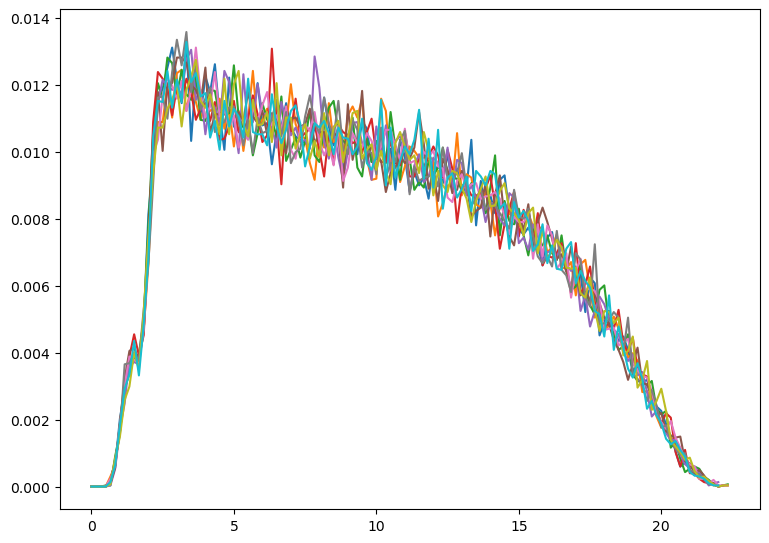

In [81]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
# ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
# ax.set_ylim(-0.1, 1.1)
for r in range(e.macro_params.total_trials):
    # plt.hist(slopes[r])
    plt.plot(tsave[r] / 60, slopes[r])
    # plt.plot([0, tsave[r][-1] / 60], [0.010569771058758868, 0.010569771058758868])

In [69]:
k = 0
m = np.mean(slopes[0][: slopes[0].size // 2])
for i in range(slopes[0].size // 2):
    new_mean = np.mean(slopes[0][i : i + slopes[0].size // 2])
    if new_mean > m:
        m = new_mean
        k = i
k, m

(13, 0.010569771058758868)

In [68]:
np.median(slopes[0][18 : 18 + slopes[0].size // 2])

0.01039763478723052

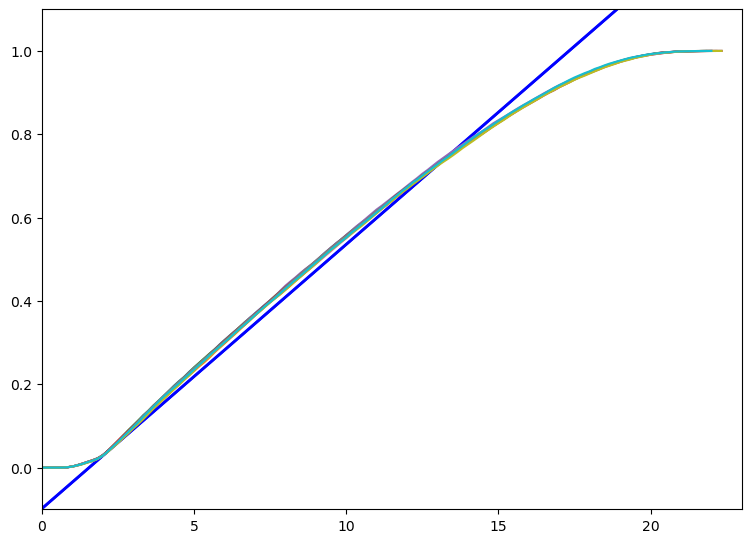

In [65]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
ax.set_ylim(-0.1, 1.1)
for r in range(e.macro_params.total_trials):
    plt.plot(tsave[r] / 60, deg_percent[r])
    plt.plot(
        (np.arange(n_save[r]) - 13 / 6) * 0.010569771058758868 * 6 + deg_percent[r][13],
        color="b",
        alpha=0.5,
        zorder=0.1,
    )

In [51]:
n_save[0]

133

In [52]:
deg_percent[0].shape[0]

133

In [75]:
np.argwhere(slopes[0] > slopes[0].max() / 2)

array([[12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],
       [77],
       [78],
       [79],
       [80],
       [81],
       [82],
       [83],
       [84],
       [85],
       [86],
       [87],
       [88],

In [79]:
degradation_rate = np.empty(e.macro_params.total_trials, dtype=np.float_)
offset = np.empty(e.macro_params.total_trials, dtype=np.float_)
deg_start_time = np.empty(e.macro_params.total_trials, dtype=np.float_)
for r in range(e.macro_params.total_trials):
    slope = np.empty(deg_percent[r].shape[0], dtype=np.float_)
    slope[0] = deg_percent[r][0]
    for t in range(1, deg_percent[r].shape[0]):
        slope[t] = deg_percent[r][t] - deg_percent[r][t - 1]
    degradation_happening = slope > slope.max() / 2
    s = np.argmax(degradation_happening)
    b, m = np.polynomial.polynomial.polyfit(
        tsave[r][degradation_happening] / 60, deg_percent[r][degradation_happening], 1
    )
    degradation_rate[r] = m
    offset[r] = b
    deg_start_time[r] = tsave[r][s] / 60

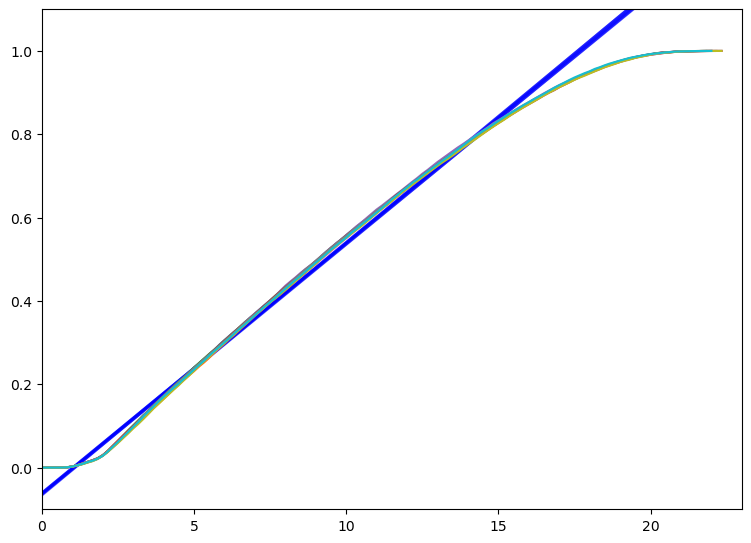

In [80]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
ax.set_ylim(-0.1, 1.1)
for r in range(e.macro_params.total_trials):
    plt.plot(tsave[r] / 60, deg_percent[r])
    plt.plot(
        np.arange((max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1) * degradation_rate[r]
        + offset[r],
        color="b",
        alpha=0.5,
        zorder=0.1,
    )

In [82]:
degradation_rate

array([0.06047394, 0.05996991, 0.05991189, 0.059681  , 0.06043641,
       0.06003008, 0.0602156 , 0.06011381, 0.0599916 , 0.06067403])

In [83]:
np.mean(degradation_rate)

0.060149827739488015